In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm

# Famma French

In [2]:
# Step 1. Collect Monthly Returns of Portfolio or Asset

ticker = "SPY"

[*********************100%***********************]  1 of 1 completed


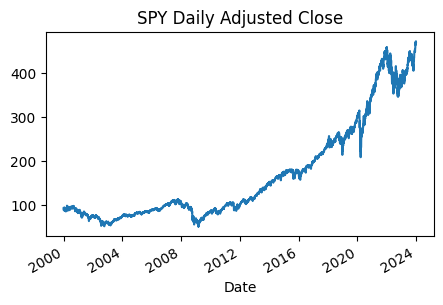

In [3]:
# use Yahoo Finance to download historical data for ticker
ticker_daily = yf.download(ticker, start="2000-01-01", end="2023-12-31")
ticker_daily["Adj Close"].plot(title=f"{ticker} Daily Adjusted Close", figsize=(5, 3))
plt.show()

In [4]:
ticker_daily['Adj Close'].resample('M').ffill().to_frame()

,Adj Close
Date,
2000-01-31,89.247940
2000-02-29,87.889030
2000-03-31,96.406769
2000-04-30,93.020866
2000-05-31,91.558357
...,...
2023-08-31,442.779541
2023-09-30,421.776520
2023-10-31,412.620361


In [5]:
# calculate monthly returns of ticker
ticker_monthly = ticker_daily["Adj Close"].resample("M").ffill().to_frame()
ticker_monthly.index = ticker_monthly.index.to_period("M")
ticker_monthly["Return"] = ticker_monthly["Adj Close"].pct_change() * 100
ticker_monthly.dropna(inplace=True)
ticker_monthly

,Adj Close,Return
Date,,
2000-02,87.889030,-1.522623
2000-03,96.406769,9.691469
2000-04,93.020866,-3.512100
2000-05,91.558357,-1.572238
2000-06,93.360397,1.968187
...,...,...
2023-08,442.779541,-1.625195
2023-09,421.776520,-4.743449
2023-10,412.620361,-2.170855


In [6]:
# Step 2: Load the monthly three factors into a dataframe
# CSV columns: , Mkt-RF, SMB, HML, RF
# The first columns represents the date
# The first row contains the column names
ff_factors_monthly = pd.read_csv(
    "./data/F-F_Research_Data_5_Factors.csv", index_col=0
)
ff_factors_monthly.index.names = ["Date"]
ff_factors_monthly.index = pd.to_datetime(ff_factors_monthly.index, format="%Y%m")
ff_factors_monthly.index = ff_factors_monthly.index.to_period("M")
ff_factors_monthly

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1963-08,5.07,-0.80,1.80,0.36,-0.35,0.25
1963-09,-1.57,-0.52,0.13,-0.71,0.29,0.27
1963-10,2.53,-1.39,-0.10,2.80,-2.01,0.29
1963-11,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
2024-03,2.83,-1.18,4.21,1.47,1.19,0.43
2024-04,-4.67,-2.56,-0.52,1.48,-0.30,0.47
2024-05,4.34,0.76,-1.66,2.98,-3.07,0.44


In [7]:
# Step 3: Calculate Excess Returns of Portfolio or Asset
# Filter factor dates to match the asset
ff_factors_subset = ff_factors_monthly[
    ff_factors_monthly.index.isin(ticker_monthly.index)
].copy()

# Step 3: Calculate excess returns for the asset
ff_factors_subset["Excess_Return"] = ticker_monthly["Return"] - ff_factors_subset["RF"]
ff_factors_subset

,Mkt-RF,SMB,HML,RMW,CMA,RF,Excess_Return
Date,,,,,,,
2000-02,2.45,18.28,-9.59,-18.65,-0.48,0.43,-1.952623
2000-03,5.20,-15.32,8.13,11.79,-1.59,0.47,9.221469
2000-04,-6.40,-5.01,7.26,7.66,5.65,0.46,-3.972100
2000-05,-4.42,-3.81,4.75,4.13,1.37,0.50,-2.072238
2000-06,4.64,9.92,-8.42,-8.31,-2.95,0.40,1.568187
...,...,...,...,...,...,...,...
2023-08,-2.39,-3.68,-1.08,3.42,-2.37,0.45,-2.075195
2023-09,-5.24,-1.79,1.45,1.85,-0.84,0.43,-5.173449
2023-10,-3.18,-4.05,0.19,2.47,-0.67,0.47,-2.640855


In [8]:
ff_factors_subset.to_csv('famma_french_values.csv')

In [9]:
# Step 4: Run the Regression Model

# Prepare the independent variables (add a constant to the model)
X = sm.add_constant(ff_factors_subset[["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]])
# The dependent variable
y = ff_factors_subset["Excess_Return"]
# Run the regression
model = sm.OLS(y, X).fit()
# Display the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     6372.
Date:                Mon, 30 Sep 2024   Prob (F-statistic):          4.14e-296
Time:                        23:48:36   Log-Likelihood:                -129.78
No. Observations:                 287   AIC:                             273.6
Df Residuals:                     280   BIC:                             299.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0339      0.031     -1.083      0.2

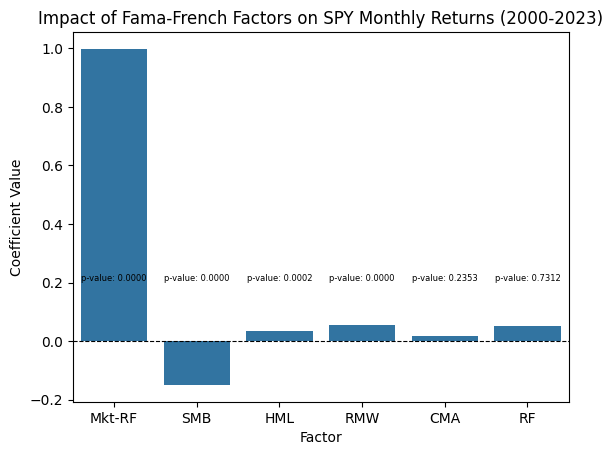

In [10]:
# Step 5.2: Plot the coefficients and their confidence intervals
factors = model.params.index[1:]  # ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]
coefficients = model.params.values[1:]
confidence_intervals = model.conf_int().diff(axis=1).iloc[1]

# Create a DataFrame
ols_data = pd.DataFrame(
    {
        "Factor": factors,
        "Coefficient": coefficients,
        "Confidence_Lower": confidence_intervals[0],
        "Confidence_Upper": confidence_intervals[1],
    }
)

# Plotting
sns.barplot(x="Factor", y="Coefficient", data=ols_data, capsize=0.2)

# Add the p-value for each factor to the plot
for i, row in ols_data.iterrows():
    plt.text(
        i,
        0.2,
        f"p-value: {model.pvalues[row['Factor']]:.4f}",
        ha="center",
        va="bottom",
        fontsize=6,
    )

plt.title(f"Impact of Fama-French Factors on {ticker} Monthly Returns (2000-2023)")
plt.xlabel("Factor")
plt.ylabel("Coefficient Value")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.show()